# Aprendizaje continuo para la clasificación de imágenes

Como respuesta a la situación actual de redes neuronales e inteligencias artificiales, donde su aprendizaje está ligado a largos entrenamiento desde cero, he desarrollado un experimento que demuestra la capacidad de la IA de avanzar y seguir aprendiendo sin la necesidad de que esta deba ser entrenada de cero.

Un entrenamientos como el que se comentaba anteriormente conlleva largos tiempos de ejecución y de espera, con costes computacionales, de electricidad, y donde una mejora en el modelo del sistema es poco rentable. Además, si la necesidad de realizar este tipo de mejores tiene una alta frecuencia, es probable que se llegue a la conclusión de que éste no resulta en el método de trabajo más adecuado.

Con la implementación del Aprendizaje Continuo es posible entrenar una red con unos datos iniciales con el objetivo de que nuestra red neuronal (NN) desarrolle una actividad específica con una calidad determinada, como por ejemplo la detección visual de matrículas españolas. En el caso de que una empresa quiera ampliar sus servicios a otro país como Japón, debe entrenar de nuevo la red, esto genera muchos inconvenientes en procesos productivos:

- Riesgo a conseguir peores resultados con la combinación de datos de España y Japón.
- Necesidad de adquirir o recuperar los datos con los que la IA había sido entrenada anteriormente. A veces no se guardan o se pierden parcial o totalmente.
- Se requiere una alta capacidad de almacenaje de datos.
- Altos tiempos de entrenamiento, entre días y semanas para este tipo de soluciones.
- Grandes costes computacionales y derivados (electricidad, personal...).
- Todos estos inconvenientes crecerán por cada nueva actualización o mejora que sea precisa hacer al modelo.
- Pérdida de poder de computación durante este periodo de tiempo en cuestión.

### Acercamiento al Task Incremental Learning 
Es muy importante que en problemas de Aprendizaje Continuo o Lifelong Learning, cuando re-entrenmos una red neuronal, no demos nuevo al modelo datos o muestras con las que esta ya ha sido entrenado anteriormente. Esto llevará a overfitting y sobre-entrenamiento. El método más efectivo resulta en entrenar a la red con únicamente los datos de la nueva tarea, y aplicar metodologías que eviten el olvida y retengan la información de tareas anteriores en el sistema. Ahí es donde juega un papel fundamental las metodolgías del Aprendizaje Continuo.
  
Para que la empresa solucione su problemas con las matrículas de Japón, se propone utilizar en modelo original entrenado para la detección de matrículas en España, que es la tarea inicial. Se selecciona la red y los parámetros obtenidos para la solución de A, y se entrenan con los datos de la nueva tarea.

- Tarea A: Detección de matriculas de España. Datos de entrenamiento: $D_{A}$
$$min_{\theta} \sum_{x_{i}, y_{i}∈D_{A}}  L(\hat{y}_{\theta}(x_{i}), y_{i})$$

Los parámetros (a minimizar) se inicializan aleatoriamente para entrenar a la red desde cero originalmente.


- Tarea B: Detección de matrículas de Japón. Datos de entrenamiento: $D_{B}$
$$min_{\theta} \sum_{x_{i}, y_{i}∈D_{B}}  L(\hat{y}_{\theta}(x_{i}), y_{i})$$

Se inicializan los parámetros (a minimizar) con la solución de la tarea A, sin necesidad de introduciar el Dataset de A.

Para las primeras pruebas del sistema se utilizarán conjuntos de datos muy comunes para el test de modelos de aprendizaje. La tarea A consisterá en detección en la clasificación de números MNIST, mientras que la segunda tarea B será la clasificación de ropa de FashionMNIST. Ambas tareas tienen cierta relación, al igual que en el caso de las matrículas.

In [1]:
import math
import torch
import random
import numpy as np
from torch import nn
from PIL import Image
from torch import optim
import torch.utils.data
from copy import deepcopy
from tqdm.notebook import tqdm
from torchvision import datasets
from torch.autograd import Variable
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from contlearn.gettrainer import one_epoch_baseline, test, var2device

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Dataset MNIST

Contiene un total de 70.000 imágenes de los números del 0 al 9 escritos a mano y su etiqueta correspondiente. Con el método utilizado, 60.000 de las imágenes serán para el entrenamiento y 10.000 para el testo o validación del modelo.

<p align="center">
    <img src="images/MNIST_data.png" height=200 width=200 >
</p>

### Dataset Fashion-MNIST

Contiene un total de 70.000 imágenes con diferentes prendas de ropa, a las que definiremos posteriormente sus etiquetas correspondientes. Tiene 10 clases y sigue la misma estructura que MNIST en cuanto a división train-test, tamaño de imágenes y distribución.

<p align="center">
    <img src="images/Fashion_data.png" height=200 width=200 >
</p>

Ambos conjuntos de imágenes tienen datos con un tamaño de 28x28 píxeles.

In [2]:
def MNIST_data(batch_size:int):
    """
    Obtengo los datos del Dataset, lo divido entre entrenamiento
    y test, y los transformo a DataLoaders para el moddelo.

    Inputs:
    batch_size = Cantidad imágenes que tendrá cada uno de los 
    grupos en los que se divide el dataset, que se pasan a la red.
    """

    mnist_train = datasets.MNIST(
        "../data", 
        train=True, 
        download=True, 
        transform=transforms.ToTensor(),
    )

    mnist_test = datasets.MNIST(
        "../data", 
        train=False, 
        download=True, 
        transform=transforms.ToTensor(),
    )

    train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle=False)

    return train_loader, test_loader

def FashionMNIST_data(batch_size:int):
    """
    Obtengo los datos del Dataset, lo divido entre entrenamiento
    y test, y los transformo a DataLoaders para el moddelo.

    Inputs:
    batch_size = Cantidad imágenes que tendrá cada uno de los 
    grupos en los que se divide el dataset, que se pasan a la red.
    """

    mnist_train = datasets.FashionMNIST(
        "../data", 
        train=True, 
        download=True, 
        transform=transforms.ToTensor(),
    )

    mnist_test = datasets.FashionMNIST(
        "../data", 
        train=False, 
        download=True, 
        transform=transforms.ToTensor(),
    )

    train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle=False)

    return train_loader, test_loader

In [3]:
# Dataset de entrenamiento y test para la tarea A. MNIST
train_loader_mnist, test_loader_mnist = MNIST_data(batch_size=32)

# Dataset de entrenamiento y test para la tarea A. FashionMNIST
train_loader_fashion, test_loader_fashion = FashionMNIST_data(batch_size=32)

Label: 4
Tamaño de la imagen: torch.Size([28, 28])


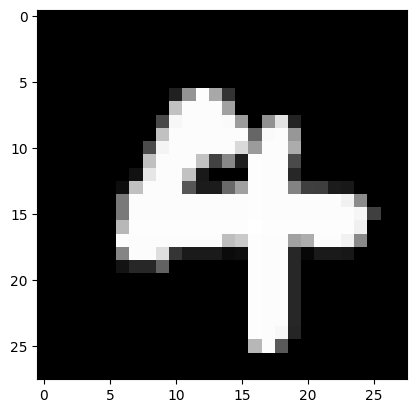

In [4]:
input_image, target_label = next(iter(train_loader_mnist)) #se selecciona una imagen aleatorio del loader creado

print("Label:",target_label[0].item())
print("Tamaño de la imagen:",input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255) #El tensor se pasa a cpu para tenerlo en memoria

plt.imshow(img) #Se visualiza la imagen MNIST

In [5]:
#Se definen los diferentes label del dataset FashionMNIST como cadenas de texto
#descriptivas en lugar numéricamente como en el caso de MNIST para mayor sencillez

#Se definen en inglés como consenso establecido
fashion_key = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

Label: Ankle boot
Tamaño de la imagen: torch.Size([28, 28])


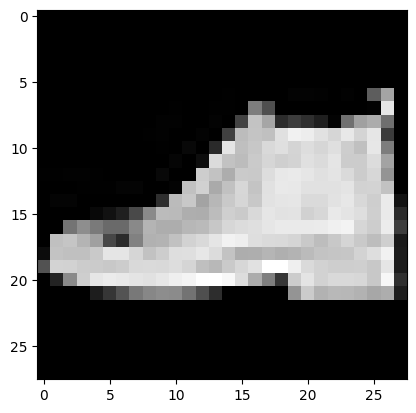

In [6]:
input_image, target_label = next(iter(train_loader_fashion)) #se selecciona una imagen aleatorio del loader creado

print("Label:",fashion_key[int(target_label[0].detach().cpu().numpy().item())])
print("Tamaño de la imagen:",input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255) #El tensor se pasa a cpu para tenerlo en memoria

plt.imshow(img) #Se visualiza la imagen MNIST

# Tarea A: Entrenamiento para clasificación de imágenes MNIST

Lo primero que voy a hacer es entrenar una red simple MLP (Perceptrón Multicapa) para la clasificación de números MNIST. Se observa una alta calidad en los resultados.

In [7]:
print('La prueba está empleado la version de PyTorch ',torch.__version__)

if torch.cuda.is_available():
    use_cuda = True
    print("Tienes", torch.cuda.device_count(), "GPUs")
    device = torch.device("cuda:0")
    print("Usando", device)
else:
    use_cuda = False
    print('No se detectan GPUs')
    device = torch.device("cpu")

La prueba está empleado la version de PyTorch  2.0.1+cu117
Tienes 1 GPUs
Usando cuda:0


### MLP 

Para las primeras pruebas a realizar se introduce una red simple, Perceptrón Multicapa conformado por un conjunto de 2 capas ocultas, una de entrada para imágenes 28x28 y otra de salida para la clasificación entre 10 clases (Fashion y MNIST).

<p align="center">
    <img src="images/MLP_network.png" height=550 width=550 >
</p>

Con ella realizré las primeras pruebas del modelo de Aprendizaje Continuo, compararé resultados entre metodologías estocásticas y continuas, y definiré una serie de puntos de mejora a realizar en el modelo.

In [8]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
        

class MLP(nn.Module):
    """
    basic multi-layer perceptron
    """
    def __init__(self, hidden_size=400):
        super(MLP, self).__init__()
        self.flat = Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 10)

    def forward(self, input):
        x = self.flat(input)
        #print("X SHAPE", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

In [9]:
model = MLP(hidden_size=256)

if torch.cuda.is_available() and use_cuda:
    model.cuda()
    
# Se prueba el comportamiento adecuado de la arquitectura
# de la red simple con una imagen de entrada

input_image, target_label = next(iter(train_loader_fashion))
input_image = var2device(input_image).squeeze(1)
print("Tamaño de la imagen --> ({}, {}, {})".format(input_image.shape[0], input_image.shape[1], input_image.shape[2]))

output = model(input_image)
print("Salida del modelo --> ({}, {})".format(output.shape[0], output.shape[1]))

Tamaño de la imagen --> (32, 28, 28)
Salida del modelo --> (32, 10)


In [10]:
def default_train(
    model, 
    epochs, 
    train_loader,
    test_loader,
    test2_loader = None,
    use_cuda=True, 
):
    """
    Esta función guarda los datos de pérdida (loss) en el conjunto de entrenamiento 
    y precisión (accuracy) en el conjunto de validación a lo largo de los epochs.

    He configurado esta función para que si se proporcionan dos conjuntos de prueba, 
    se pueda observar cómo cambia la precisión en ambas pruebas conjuntamente durante 
    el entrenamiento.

    Inputs:
    model = Modelo de la arquitectura de la red (entrenado o de cero).
    epochs = Cantidad de épocas en las que será entrenado el modelo.
    train_loader: DataLoader con el conjunto de datos de entrenamiento para tarea B.
    test_loader: DataLoader con el conjunto de datos de test para tarea B.
    test2_loader: DataLoader con el conjunto de datos de test para tarea A.
    use_cuda = Selección de uso de GPU (True) o CPU (False).
    """
    if torch.cuda.is_available() and use_cuda:
        model.cuda() #modelo a GPU
        
    train_loss, val_acc, val2_acc = [], [], []
    
    for epoch in tqdm(range(epochs)):

        # Se calcuula la pérdida promedio para cada imagen,
        # en cada uno de los epochs del entrenamiento
        epoch_loss = one_epoch_baseline(model,train_loader)
        train_loss.append(epoch_loss) #se guardan las pérdidas para visualizar su variación 
        
        acc = test(model,test_loader) # Precisión del modelo en validación 1
        val_acc.append(acc.detach().cpu().numpy()) #se guardan las precisiones para visualizar su variación
        
        if test2_loader is not None:
            acc2 = test(model,test2_loader) # Precisión del modelo en validación 2
            val2_acc.append(acc2.detach().cpu().numpy()) #se guardan las precisiones para visualizar su variación
            
    return train_loss, val_acc, val2_acc, model 

In [11]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# El entrenamiento del modelo lleva alrededor de 7/8 minutos con GPU
train_loss, val_acc, val2_acc,  model = default_train(
    model,
    epochs = 25, # 25 epochs de entrenamiento para MNIST
    train_loader = train_loader_mnist,
    test_loader = test_loader_mnist,
)

  0%|          | 0/25 [00:00<?, ?it/s]

In [12]:
# Se guarda el modelo entrenado en la carpeta 'models'
model = model.cpu()
torch.save(model, "models/taskA.pth")

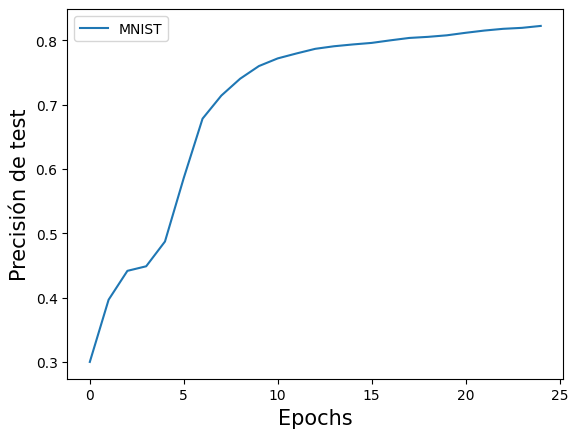

In [13]:
plt.figure()
plt.plot(val_acc, label='MNIST')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Precisión de test', fontsize=15)
plt.legend()
plt.show()

In [14]:
# Se permite cargar el modelo pre entrenado en lugar de realizar entrenamientos de cero
#model = torch.load("basemodel.pth")

if torch.cuda.is_available() and use_cuda:
    model.cuda() #modelo a GPU

acc_mnist = test(model,test_loader_mnist) #Precisión actual del modelo para la tarea A
acc_fashion = test(model,test_loader_fashion) #Precisión actual del modelo para la tarea B
    
print('Precisión en Tarea A (MNIST): {} %'.format(acc_mnist*100))
print('Precisión en Tarea B (Fashion): {} %'.format(acc_fashion*100))

Precisión en Tarea A (MNIST): 82.26000213623047 %
Precisión en Tarea B (Fashion): 6.529999732971191 %


  
Como se puede ver, el modelo ha aprendido la primera tarea A, mientras que por el momento su aprendizaje en la tarea B es nulo (cercano una clasificación aleatoria).

Se va a entrenar el modelo resultado de la tarea A para aprender sobre la tarea B. El objetivo es mantener el conocimiento de aquellos procesos o tareas anteriores, mientras aprende de los nuevos.

### SGD (Stochastic Gradient Descent)

Re-entrenamiento predeterminado de una red, donde sus parámetros serán actualizados sin seguir nigún tipo de penalización o lógica para mantener el conocimiento de tareas anteriores.

In [15]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc,  model = default_train(
    model,
    epochs = 25,
    train_loader = train_loader_fashion,
    test_loader = test_loader_fashion,
    test2_loader = test_loader_mnist,
)

  0%|          | 0/25 [00:00<?, ?it/s]

In [16]:
torch.save(model, "models/taskA_B.pth")

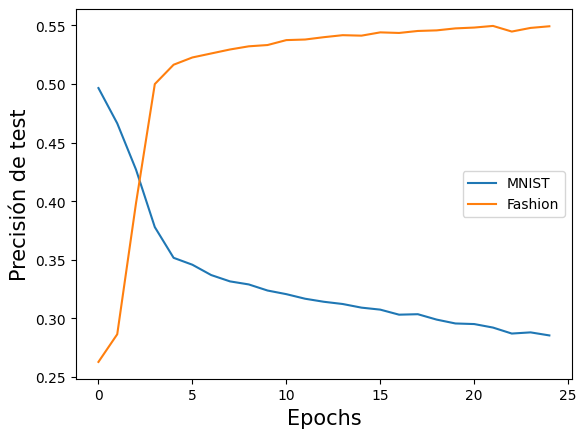

In [17]:
plt.figure()
plt.plot(val2_acc, label='MNIST')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Precisión de test', fontsize=15)
plt.plot(val_acc, label='Fashion')
plt.legend()
plt.show()

### Olvido Catastrófico o Catastrophic Forgetting

Uno de los principales problemas a resolver en el aprendizaje continuo, es la pérdida de conocimiento o rendimiento en las tareas aprendidas a medida aprende de nuevas. En este caso, aprender Fashion MNIST degrada el rendimiento en MNIST. Eeto se debe a que algunos de los parámetros o pesos, utilizados para MNIST cambian y son actualizados en un grado mayor de lo que resultaba necesario para MNIST, con el objetivon de volverse útiles para Fashion MNIST.

En estas circunstancias y para diferentes pruebas, es habitual encontrarse un rendimiento de FashionMNIST (Tarea B) desde el 8-10% hasta un 35-45%, mientras que MNIST pasa de un 80-90% hacia menos de un 25-30%.

<p align="center">
    <img src="images/SGD.png" height=550 width=550 >
</p>

# EWC (Elastic Weight Consolidation)

Para evitar la pérdida de información en nuestro sistema o red neuronal, existen diferentes soluciones como la regularización de los pesos de la red para optimizar la plasticidad y estabilidad de la red. Se define así, un parámetro $ \lambda $ para definir la escala entre estos factores de aprendizaje.

- Plasticidad: Es la capacidad que tiene un modelo ya entrenado de adaptarse (sus parámetros y pesos) a la nueva información de la tarea B en este caso.
- Estabilidad: Seguridad de que el modelo va a mantener el conocimiento aprendido previamente de la tarea A, durante el nuevo entrenamiento para la tarea B.

EWC consigue mejorar significativamente los resultados en el área de aprendizaje incremental o durante toda la vida del modelo. Lo consigue definiendo un valor adecuado para la plasticidad-estabilidad del modelo y creando una función de penalización que se encarga de penalizar con respecto a la función de coste, con mayor peso, aquellos cambios que se preoducen en los parámetros de mayor importancia para la tarea A, es decir, que tienen más información de la misma. Esto permite que el modelo mantenga el conocimiento de estos parámetros mientras todos aquellos otros con poca relevancia para la/s tarea/s anterior/es, se actualizan con respecto a la nueva tarea B debido a tener un grado de penalización mucho menor.

### Comportamiento y explicación

La figura inferior muestra el efecto de la Consolidación de Pesos Elásticos en, $\theta^{*}$ que equivale a los pesos aprendidos por una red nueronal para llevar a cabo una tarea A, mostrados como un vector en el espacio de vectores. La flecha azul indica un ejemplo del olvido catastrófico (SGD), donde los pesos se alejan de la región que permite a la Red Nueronal actuar bien en la tarea A (área gris), hacia el centro de la región que permite a la red actuar bien en la tarea B (área amarilla). La flecha verde la actualización de los pesos $\theta^{*}$ regularizados por una penalización L2 $\alpha (\theta_{i} - \theta_{A , i}^{*})^{2}$ que provoca que estos se muevan hacia la región amarilla de la tarea B, sin importarle la forma de la área gris de la tarea A. El vector deseado tras la actualización de EWC es el indicado con la flecha roja, que mueve los pesos de la Red Neuronala una región capaz de actuar bien en ambas tareas A y B.

<p align="center">
    <img src="images/EWC_functioning.jpg" height=500 width=500 >
</p>

EWC genera el movimiento de pesos $\theta^{*}$ siguiendo la flecha roja, modificando la función de pérdida cuando rentrena una Red Neuronal que ya ha sido entrenada hasta la converger usando la función de pérdida para la tarea A, $L_{A}$, dejando unos pesos $\theta_{A}$. Cuando se entrena la RN en la tarea B usando $L_{B}$, se añade un término que penaliza los cambios realizados en los pesos que están, tanto alejados de $\theta_{A}$, ie $(\theta_{i} - \theta_{A , i}^{*})^{2}$, y también a aquellos pesos con valores altos en $F_{i}$ que genera la región gris de A.

$$L \left(\right. \theta \left.\right) = L_{B} \left(\right. \theta \left.\right) + \underset{i}{\sum} \frac{\lambda}{2} F_{i} \left(\theta_{i} - \theta_{A , i}^{*}\right)^{2} $$

### Penalización en los pesos de la RN

$F_{i}$ es la diagonal de la matriz de información de Fisher, que estudia la relación entre los parámetros de la red y sus resultados. Queremos usar los componentes diagonales en de la Matriz de Información de Fisher para identificar qué parámetros son más importantes para la tarea A y aplicarles pesos más altos para que no cambien. Mientras que para aprender la tarea B, se deben cambiar los pesos con valores pequeños para A.
  
En caso de haber múltiples tareas, el sistema de EWC siempre trata de mantener el valor de los parámetros aprendidos para las tareas anteriores, bien sea aplicando diferentes penalizaciones para cada tarea o solamente una combinación cuadrática de ambas.

In [11]:
# En lugar de volver a examinar cada ejemplo antiguo de MNIST para construir 
# la Matriz de Información Fisher, se utilizarán la cantidad de imágenes de 
# entre todas las tareas anteriores para calcular una aproximación de la matriz.

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

num_batches = 16 # se define la cantidad de batches a estudiar, 16 batches x 32 imágenes = 512 muestras
old_tasks = []

for sample in range(num_batches):
    input_batch, target_batch = next(iter(train_loader_mnist))
    for image in input_batch:
        old_tasks.append(image)
    
print("Número de muestras =", len(old_tasks))

Número de muestras = 512


In [12]:
# Para la comparación se carga el modelo anteriormente entrenado para la tarea A
model = torch.load("models/taskA.pth")

if torch.cuda.is_available() and use_cuda:
    model.cuda()    

acc = test(model,test_loader_mnist)
print("Precisión en tarea A (MNIST): {} %".format(acc*100))

Precisión en tarea A (MNIST): 82.26000213623047 %


In [56]:
class EWC(object):
    
    """
    Clase para calcular la Matriz de Información Fisher 
    utilizada en la sección de Consolidación de Pesos 
    Elásticos de la función de pérdida.
    """
    
    def __init__(self, model: nn.Module, dataset: list):
        self.model = model #pretrained model
        self.dataset = dataset #samples from the old task or tasks
        
        # n es la cadena de la matriz de parámetros p, pesos de la red
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        print(self.params)
        # self.params hace referencia a todos los pesos que pueden ser ser actualizados
        
        # Se calcula previamente el cambio de los parámetros respecto a los de la 
        # anterior tarea, ya que los parámetros van a cambiar constantemente por
        # cada propagación hacia atrás y por cada actualización del optimizador
        self._means = {}
        # Se hace una copia de los pesos originales
        for n, p in deepcopy(self.params).items():
            self._means[n] = var2device(p.data)
        
        # Se clcula la diagonal de la Matriz de Información de Fisher
        self._precision_matrices = self._Fisher_diagonal()

    def _Fisher_diagonal(self):
        
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            # Copia de capa de la red a ceros con la forma del n elemento de la matriz de precisión de EWC
            p.data.zero_()
            precision_matrices[n] = var2device(p.data)

        # El modelo calcula el gradiente pero sin actualizar el modelo.
        # Para actualizar se espera a combinar la pérdida de EWC con el
        # término de pérdida de la nueva tarea.
        self.model.eval()
        for input in self.dataset:
            self.model.zero_grad()
            # con squeeze se elimina el la dimensión del canal, para imágenes en escala de grises
            # bs,1,h,w -> bs,h,w
            input = input.squeeze(1)
            input = var2device(input)
            output = self.model(input).view(1, -1)
            label = output.max(1)[1].view(-1)
            loss = F.nll_loss(F.log_softmax(output, dim=1), label) # Cálculo de la pérdida y BackProp
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss
    
# Se coloca el modelo ya entrenado con los diferentes muestras de las tareas 
# anteriores (512) para calcular la Matriz de Fisher
ewc = EWC(model, old_tasks)

{'fc1.weight': Parameter containing:
tensor([[-0.0113, -0.0102, -0.0205,  ...,  0.0323, -0.0329, -0.0262],
        [ 0.0094,  0.0025,  0.0185,  ...,  0.0062,  0.0016,  0.0046],
        [ 0.0202, -0.0218,  0.0295,  ...,  0.0081,  0.0251, -0.0074],
        ...,
        [ 0.0285,  0.0185,  0.0248,  ...,  0.0197,  0.0338, -0.0160],
        [ 0.0298,  0.0131, -0.0328,  ..., -0.0059, -0.0276,  0.0057],
        [-0.0315, -0.0177, -0.0283,  ...,  0.0023,  0.0133, -0.0171]],
       device='cuda:0', requires_grad=True), 'fc1.bias': Parameter containing:
tensor([-0.0093,  0.0248, -0.0024, -0.0271,  0.0441,  0.0906,  0.0289, -0.0057,
         0.0125, -0.0352,  0.0280, -0.0335, -0.0094,  0.0109,  0.0041,  0.0107,
         0.0320, -0.0355,  0.0205, -0.0500, -0.0131,  0.0208, -0.0845, -0.0205,
         0.0031,  0.0665, -0.0238,  0.0428,  0.0615, -0.0119, -0.0049,  0.0107,
        -0.0340, -0.0698, -0.0051, -0.0143,  0.0368,  0.0390, -0.0310,  0.0294,
         0.0838, -0.0261,  0.0370, -0.0435, -0.005

In [57]:
precision_matrices = {}
for n, p in deepcopy(ewc.params).items():
    p.data.zero_()
    precision_matrices[n] = var2device(p.data)
    print("Forma de la matriz W -->", precision_matrices[n].shape)
    print("Norm de la matriz = ",torch.norm(precision_matrices[n]).item()) #el valor debe ser 0 porque aun no se ha cambiado sus valores
    break

Forma de la matriz W --> torch.Size([256, 784])
Norm de la matriz =  0.0


Tamaño imágenes de entrada --> torch.Size([28, 28])
[0.0, 0.0, 0.0, 0.0, 1.0791967, 0.0, 4.6037493, 0.0, 0.0, 0.0]
Número con mayor confianza: 6
Valor de pérdida: 0.1039804220199585


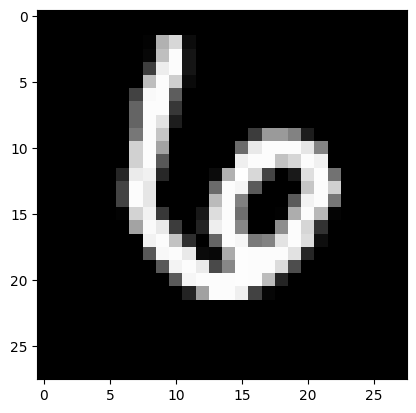

In [15]:
ewc.model.eval()
for input in ewc.dataset:
    ewc.model.zero_grad()
    input = input.squeeze(1)
    input = var2device(input)
    output = ewc.model(input).view(1, -1)
    label = output.max(1)[1].view(-1)
    loss = F.nll_loss(F.log_softmax(output, dim=1), label)
    loss.backward()    
    break

print("Tamaño imágenes de entrada -->", input.shape[1:])
img = Image.fromarray(input[0].detach().cpu().numpy()*255)
plt.imshow(img)

print(list(output.detach().cpu().numpy()[0]))
print("Número con mayor confianza:",label.item())
print("Valor de pérdida:",loss.item())

In [16]:
for n, p in ewc.params.items():
    precision_matrices[n].data += p.grad.data ** 2 / len(ewc.dataset)
    #print(precision_matrices[n])
    print("Norm de la matriz",torch.norm(precision_matrices[n]).item()) #se empieza a ver una pequeña variación
    break

Norm de la matriz 0.00010550613660598174


In [17]:
ewc.penalty(model)

# Compruebo que el modelo seleccionado para rentrenar con EWC ya esta entrenado previamente para otra tarea
acc = test(model,test_loader_mnist)
print("Precisión en tarea A (MNIST) {} %".format(acc*100))

Precisión en tarea A (MNIST) 82.26000213623047 %


In [59]:
def ewc_train_loss(
    ewc: EWC, 
    importance: float,
    model: nn.Module, 
    data_loader: torch.utils.data.DataLoader, 
    lr = 1e-3,
):
    """
    Cálculo de la pérdida del modelo durante cada epoch del entrenamiento.
    Permite calcular el promedio de la pérdida para cada imagen del 
    DataLoader, y ver su variación a lolargo de las diferentes iteraciones.
    
    Inputs:
    ewc = objeto de la clase EWC().
    importance = Escala de Plasticidad-Estabilidad. Si tiende a inifito trata de 
    mantener información de tareas anteriores, si tiendo a cero sus parámetros
    cambian altamente.
    model = Modelo de la arquitectura de la red (entrenado o de cero).
    epochs = Cantidad de épocas en las que será entrenado el modelo.
    data_loader: DataLoader con el conjunto de datos (imágenes).
    lr = Hiperparámetro de learning rate para el entrenamiento.
    """
    model.train()
    epoch_loss = 0
    optimizer = optim.SGD(params=model.parameters(), lr=lr)
    for input, target in data_loader:
        # no need for the channel dim
        # bs,1,h,w -> bs,h,w
        input = input.squeeze(1) 
        input, target = var2device(input), var2device(target)
        optimizer.zero_grad()
        output = model(input)
        loss = F.cross_entropy(output, target) + importance * ewc.penalty(model)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)

def ewc_training(
    ewc,
    importance,
    model, 
    epochs, 
    train_loader,
    test_loader,
    test2_loader = None,
    use_cuda=True, 
):
    """
    Esta función guarda los datos de pérdida (loss) en el conjunto de entrenamiento 
    y precisión (accuracy) en el conjunto de validación a lo largo de los epochs.

    He configurado esta función para que si se proporcionan dos conjuntos de prueba, 
    se pueda observar cómo cambia la precisión en ambas pruebas conjuntamente durante 
    el entrenamiento.

    Inputs:
    ewc = objeto de la clase EWC().
    importance = Escala de Plasticidad-Estabilidad. Si tiende a inifito trata de 
    mantener información de tareas anteriores, si tiendo a cero sus parámetros
    cambian altamente.
    model = Modelo de la arquitectura de la red (entrenado o de cero).
    epochs = Cantidad de épocas en las que será entrenado el modelo.
    train_loader: DataLoader con el conjunto de datos de entrenamiento para tarea B.
    test_loader: DataLoader con el conjunto de datos de test para tarea B.
    test2_loader: DataLoader con el conjunto de datos de test para tarea A.
    use_cuda = Selección de uso de GPU (True) o CPU (False).
    """
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
        
    train_loss, val_acc, val2_acc = [], [], []
    
    for epoch in tqdm(range(epochs)):

        epoch_loss = ewc_train_loss(ewc,importance, model,train_loader)
        train_loss.append(epoch_loss)
        
        acc = test(model,test_loader)
        val_acc.append(acc.detach().cpu().numpy())
        
        if test2_loader is not None:
            acc2 = test(model,test2_loader)
            val2_acc.append(acc2.detach().cpu().numpy())
            
    return train_loss, val_acc, val2_acc, model 

In [19]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc, model = ewc_training(
    ewc = ewc,
    importance = 1000,
    model = model, #le pasamos el modelo entrenado para la tarea A
    epochs = 25,
    train_loader = train_loader_fashion,
    test_loader = test_loader_fashion,
    test2_loader = test_loader_mnist,
)

  0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

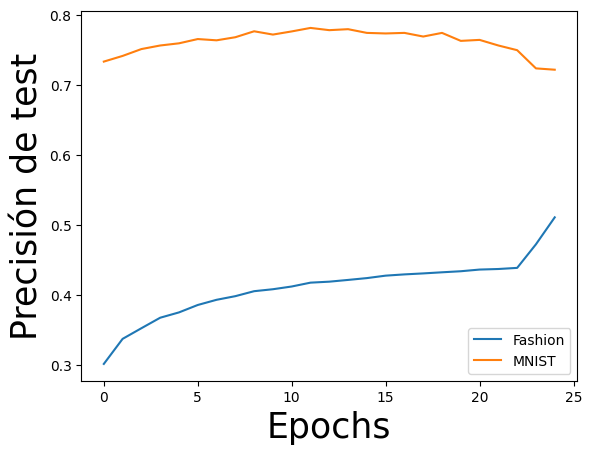

In [27]:
plt.figure()
plt.plot(val_acc, label='Fashion')
plt.plot(val2_acc, label='MNIST')
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Precisión de test', fontsize=25)
plt.legend()
plt.show()

La implementación de EWC en el modelo de aprendizaje continuo tiene grandes mejoras en los resultados del sistema. Al contrario que mediante un parendizaje con Stochatic Gradient Descent, el modelo olvida en menor medida, perdiendo al rededor de un 10% de su conocimiento en la tarea A. Además el conocimiento de la nueva tarea B sube al rededor de un 5-10% con respecto a SGD. Tal vez se deba bajar el valor de del parámetro para aumentar la plasticidad durante el entrenamiento.

<p align="center">
    <img src="images/EWC_result.png" height=550 width=550 >
</p>

In [28]:
# save the trained model
model = model.cpu()
torch.save(model, "models/EWC_taskA_B.pth")

### Mejoras a tener en cuenta

Aun así, los resultados pueden ser bastante mejorables con las siguientes acciones:

- Optimización del parámetro de Plasticidad-Estabilidad.
- Uso de una Red Neuronal más adapta a imágenes (CNN).
- Implementación de diferentes tipos de regularizaciones y otros métodos (iCArl, GEM, L2...).
- Implementación de otras metodologías para el aprendizaje como Class Incremental Learning.

### Uso de una Red Neuronal Convolucional (CNN)

In [20]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 classes for classification

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
model = CNN()
#model = SimpleCNN()
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [22]:
# Creo una función función para el entrenamiento y otra para el test de la red CNN
# ya que resulta necesario redimensionar las imágenes de entrada para estas ser
# admitidas de forma correcta en la arquitectura de red neuronal convolucional con
# dos capaces convoluciones, y una salida de 32 imágenes de entre 10 clases posibles.

def test_CNN(model, loader):
    """
    Se obtiene la precisión de validación final del
    modelo para un conjunto de datos de test de entrada.
    
    Inputs:
    model = modelo a usar para validación del test set.
    loader = DataLoader que equivale al conjunto de datos de test.
    """
    count = 0
    total = 0
    correct = 0
    
    # Listas para guardar y visualiar valores de pérdida y precisión
    predictions_list = []
    labels_list = []
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        batch_size = images.size(0)
        images = images.unsqueeze(1)  # Se añade la dimensión del canal
        reshaped_images = images.view(batch_size, 1, 28, 28)  
        test = Variable(reshaped_images).to(device) 
    
        outputs = model(test) #predicciones del modelo para la entrada

        #se selecciona la predicción con mayor confianza
        predictions = torch.max(outputs, 1)[1].to(device)
        correct += (predictions == labels).sum() #se compara predicción y etiqueta
        total += len(labels)
    
    accuracy = correct / total

    #Solamente me interesa sacar la precisión del modelo para test
    return accuracy


def CNN_train(model, lr, epochs, loader, test_loader=None, test2_loader=None):
    """
    Red neuronal convolucional (CNN) que toma imágenes de entrada en 
    escala de grises 28x28 y predice entre 10 clases posibles.

    Inputs:
    model = modelo a entrenar, entrenado o de cero.
    lr = learning rate del optimizador para el entrenamiento.
    loader = DataLoader de entrenamiento.
    test_loader = DataLoader de test (mismo dataset que 'loader').
    test2_loader = DataLoader de test para un segundo dataset.
    """
    model.to(device)  #modelo a GPU
    error = nn.CrossEntropyLoss()
    
    learning_rate = lr
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #print(model)
    
    count = 0
    # Listas para guardar y visualiar valores de pérdida y precisión
    loss_values = []
    accuracy_values = []
    
    # Conjunto de las predicciones realizadas por el modelo y los labels reales,
    # para comparar la precisión del modelo ante las imágenes de entrada.
    predictions_list = []
    labels_list = []

    # Listas para almacenar la precisión de validación de MNIST y más test loaders
    val_acc = []
    val2_acc = []

    #Entrenamiento del modelo CNN
    for epoch in range(epochs):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            batch_size = images.size(0)
            images = images.unsqueeze(1)  # Se añade la dimensión del canal
            reshaped_images = images.view(batch_size, 1, 28, 28)  
            train = Variable(reshaped_images)
            labels = Variable(labels)
            
            # Propagación hacia delante de la red
            outputs = model(train)
            loss = error(outputs, labels)
            
            # El gradiete se inicializa a cero para evitar una alteración a lo largo de los batches
            optimizer.zero_grad()
            
            # Propagación hacia atrás del error
            loss.backward()
            
            # Se optimizan los parámetros tras el backward propagation
            optimizer.step()
            count += 1 #se actualiza las iteraciones del entrenamiento
        
            # Test del modelo CNN
            if not (count % 50):
                total = 0
                correct = 0
            
                acc = test_CNN(model, test_loader)
                val_acc.append(acc) #se guardan las precisiones para visualizar su variación

                if test2_loader is not None:
                    acc2 = test_CNN(model, test2_loader)
                    val2_acc.append(acc2)
                
                loss_values.append(loss.data) #se guardan todos los valores de pérdida para visualizar su variación
            
            if not (count % 500):
                print("Iteración número {}, Loss = {}, Acc = {}".format(count, loss.data, acc))

    return model, loss_values, val_acc, val2_acc

In [11]:
# El modelo se entrena para el Dataset MNIST con su loader de entrenamiento y test

model, loss_list, test_acc, test_acc2 = CNN_train(model, lr=0.001, epochs=3, loader=train_loader_mnist, test_loader=test_loader_mnist)

C:\Users\cesarabilleira\anaconda3\envs\continual\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteración número 500, Loss = 0.018269099295139313, Acc = 0.9572999477386475
Iteración número 1000, Loss = 0.24754610657691956, Acc = 0.9698999524116516
Iteración número 1500, Loss = 0.005004690494388342, Acc = 0.973099946975708
Iteración número 2000, Loss = 0.17385652661323547, Acc = 0.9784999489784241
Iteración número 2500, Loss = 0.05093191936612129, Acc = 0.9754999876022339
Iteración número 3000, Loss = 0.07108132541179657, Acc = 0.9693999886512756
Iteración número 3500, Loss = 0.02181055210530758, Acc = 0.9746999740600586
Iteración número 4000, Loss = 0.10912279784679413, Acc = 0.9724999666213989
Iteración número 4500, Loss = 0.00318385218270123, Acc = 0.9819999933242798
Iteración número 5000, Loss = 0.0030166609212756157, Acc = 0.9809999465942383
Iteración número 5500, Loss = 0.002064329106360674, Acc = 0.9883999824523926


In [12]:
torch.save(model.state_dict(), "models/CNN_A.pth")
print("Modelo guardado correctamente.")

Modelo guardado correctamente.


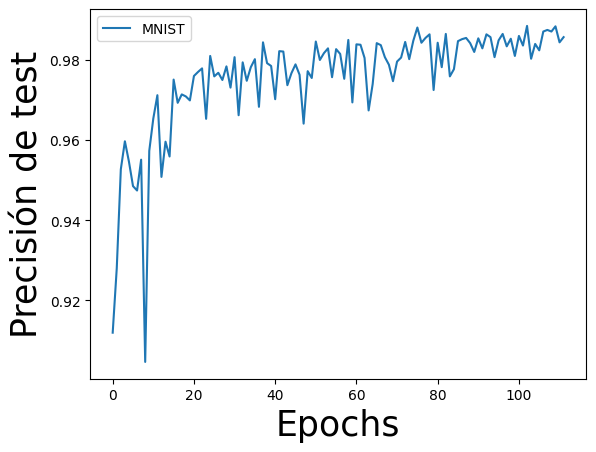

In [13]:
# Convertir los tensores a numpy arrays en la CPU
accuracy = [acc.item() for acc in test_acc]

plt.figure()
plt.plot(accuracy, label='MNIST')
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Precisión de test', fontsize=25)
plt.legend()
plt.show()

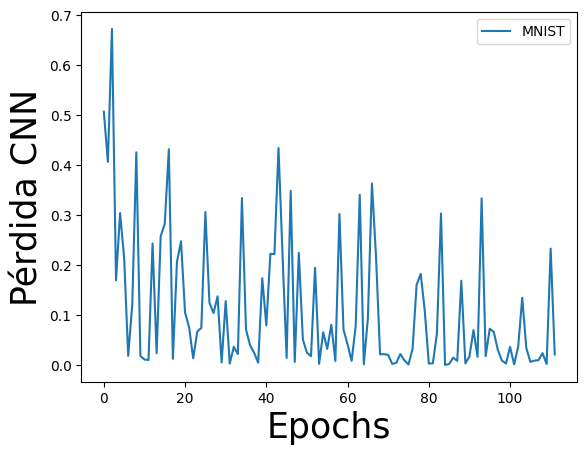

In [14]:
# Convertir los tensores a numpy arrays en la CPU
loss = [l.item() for l in loss_list]

plt.figure()
plt.plot(loss, label='MNIST')
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Pérdida CNN', fontsize=25)
plt.legend()
plt.show()

In [25]:
#loaded_model = SimpleCNN()  # Create an instance of your model
loaded_model = CNN()
loaded_model.load_state_dict(torch.load("models/CNN_A.pth")) #se carga el modelo pre-entrenado si se desea

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)  # Modelo cargado a GPU

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [26]:
mnist_accuracy_CNN = test_CNN(loaded_model, test_loader_mnist) #Se estudia la calidad de la CNN para MNIST
print('Precisión en tarea A (MNIST): {} %'.format(mnist_accuracy_CNN*100)) 

fashion_accuracy_CNN = test_CNN(loaded_model, test_loader_fashion) #Se estudia la calidad de la CNN para Fashion
print('Precisión en tarea B (Fashion): {} %'.format(fashion_accuracy_CNN*100))

C:\Users\cesarabilleira\anaconda3\envs\continual\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Precisión en tarea A (MNIST): 98.45999145507812 %
Precisión en tarea B (Fashion): 5.619999885559082 %


Algo que destaca en el uso de una Red Neuronal Convolucional (CNN) con respecto a un Perceptrón MultiCapa (MLP), es el alto rendimiento que el modelo presenta a la clasificación de la tarea A para que ha sido entrenada. Por otro lado, esto no significa que los resultados en la nueva tarea B sean buenos, esto significa que ahora podemos entrenar la red con el dataset $D_{B}$ como un reto para que el modelo aprende sin olvidar de A.

In [40]:
model, loss_list, val_acc, val_acc2 = CNN_train(loaded_model, lr=0.001, epochs=3, 
                                                loader=train_loader_fashion, 
                                                test_loader=test_loader_fashion,
                                                test2_loader=test_loader_mnist)

Iteración número 500, Loss = 0.38006842136383057, Acc = 0.8467999696731567
Iteración número 1000, Loss = 0.36764270067214966, Acc = 0.8732999563217163
Iteración número 1500, Loss = 0.4414648115634918, Acc = 0.886199951171875
Iteración número 2000, Loss = 0.1701551228761673, Acc = 0.8905999660491943
Iteración número 2500, Loss = 0.18018986284732819, Acc = 0.8930999636650085
Iteración número 3000, Loss = 0.27976101636886597, Acc = 0.8984999656677246
Iteración número 3500, Loss = 0.19115373492240906, Acc = 0.8981999754905701
Iteración número 4000, Loss = 0.2061643898487091, Acc = 0.8977999687194824
Iteración número 4500, Loss = 0.1318398416042328, Acc = 0.8959999680519104
Iteración número 5000, Loss = 0.13465407490730286, Acc = 0.898099958896637
Iteración número 5500, Loss = 0.2642185389995575, Acc = 0.9065999984741211


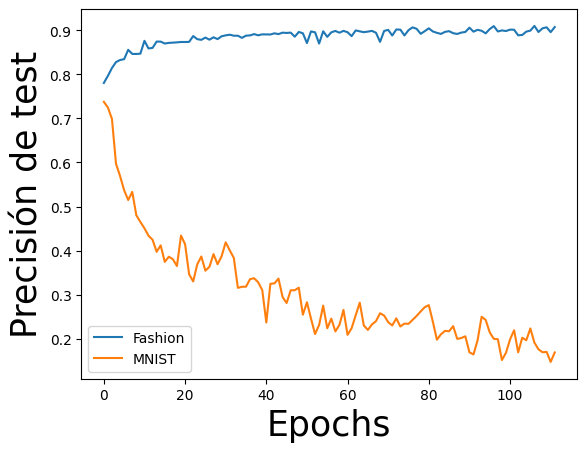

In [41]:
# Convertir los tensores a numpy arrays en la CPU
accuracy = [acc.item() for acc in val_acc]
accuracy2 = [acc.item() for acc in val_acc2]

plt.figure()
plt.plot(accuracy, label='Fashion')
plt.plot(accuracy2, label='MNIST')
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Precisión de test', fontsize=25)
plt.legend()
plt.show()

In [76]:
def EMNIST_data(batch_size:int):
    """
    Obtengo los datos del Dataset, lo divido entre entrenamiento
    y test, y los transformo a DataLoaders para el moddelo.

    Inputs:
    batch_size = Cantidad imágenes que tendrá cada uno de los 
    grupos en los que se divide el dataset, que se pasan a la red.
    """

    mnist_train = datasets.EMNIST(
        "../data", 
        train=True, 
        download=True, 
        transform=transforms.ToTensor(),
        split='mnist',
    )

    mnist_test = datasets.EMNIST(
        "../data", 
        train=False, 
        download=True, 
        transform=transforms.ToTensor(),
        split='mnist',
    )

    train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle=False)

    return train_loader, test_loader

In [68]:
# Dataset de entrenamiento y test para la tarea B. EMNIST
train_loader_emnist, test_loader_emnist = EMNIST_data(batch_size=32)

Label: 6
Tamaño de la imagen: torch.Size([28, 28])


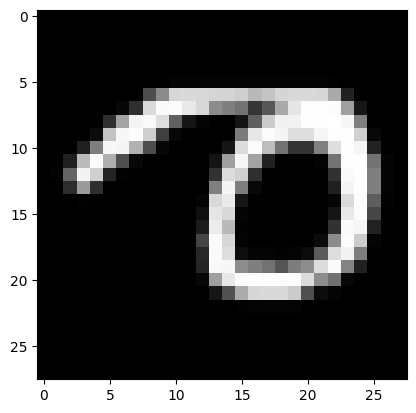

In [69]:
input_image, target_label = next(iter(train_loader_emnist)) #se selecciona una imagen aleatorio del loader creado

print("Label:",target_label[0].item())
print("Tamaño de la imagen:",input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255) #El tensor se pasa a cpu para tenerlo en memoria

plt.imshow(img) #Se visualiza la imagen EMNIST

In [51]:
mnist_accuracy_CNN = test_CNN(loaded_model, test_loader_mnist) #Se estudia la calidad de la CNN para MNIST
print('Precisión en tarea A (MNIST): {} %'.format(mnist_accuracy_CNN*100)) 

emnist_accuracy_CNN = test_CNN(loaded_model, test_loader_emnist) #Se estudia la calidad de la CNN para Cifar10
print('Precisión en tarea B (Cifar10): {} %'.format(emnist_accuracy_CNN*100))

Precisión en tarea A (MNIST): 98.3899917602539 %


NameError: name 'test_loader_emnist' is not defined

In [115]:
torch.save(model.state_dict(), "models/CNN_A_B.pth")
print("Modelo guardado correctamente.")

Modelo guardado correctamente.


In [48]:
mnist_accuracy_CNN = test_CNN(model, test_loader_mnist) #Se estudia la calidad de la CNN para MNIST
print('Precisión en tarea A (MNIST): {} %'.format(mnist_accuracy_CNN*100)) 

fashion_accuracy_CNN = test_CNN(model, test_loader_fashion) #Se estudia la calidad de la CNN para Fashion
print('Precisión en tarea B (Fashion): {} %'.format(fashion_accuracy_CNN*100))

Precisión en tarea A (MNIST): 9.800000190734863 %
Precisión en tarea B (Fashion): 9.999999046325684 %


Con la implementación de una red CNN más orientada a la clasificación de imágenes, aunque la calidad de la tarea A baja del 98,6% al 90%, mientras que la tarea B de un 10-15% al 90-91%. Ahora ambas tareas se encuentran realmente parejas en cuanto a nivel de precisión se refiere.

In [63]:
class EWC(object):
    
    """
    Clase para calcular la Matriz de Información Fisher 
    utilizada en la sección de Consolidación de Pesos 
    Elásticos de la función de pérdida.
    """
    
    def __init__(self, model: nn.Module, dataset: list):
        self.model = model #pretrained model
        self.dataset = dataset #samples from the old task or tasks
        
        # n es la cadena de la matriz de parámetros p, pesos de la red
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        print(self.params)
        # self.params hace referencia a todos los pesos que pueden ser ser actualizados
        
        # Se calcula previamente el cambio de los parámetros respecto a los de la 
        # anterior tarea, ya que los parámetros van a cambiar constantemente por
        # cada propagación hacia atrás y por cada actualización del optimizador
        self._means = {}
        # Se hace una copia de los pesos originales
        for n, p in deepcopy(self.params).items():
            self._means[n] = var2device(p.data)
        
        # Se clcula la diagonal de la Matriz de Información de Fisher
        self._precision_matrices = self._Fisher_diagonal()

    def _Fisher_diagonal(self):
        
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            # Copia de capa de la red a ceros con la forma del n elemento de la matriz de precisión de EWC
            p.data.zero_()
            precision_matrices[n] = var2device(p.data)

        # El modelo calcula el gradiente pero sin actualizar el modelo.
        # Para actualizar se espera a combinar la pérdida de EWC con el
        # término de pérdida de la nueva tarea.
        self.model.eval()
        for input in self.dataset:
            self.model.zero_grad()
            # con squeeze se elimina el la dimensión del canal, para imágenes en escala de grises
            # bs,1,h,w -> bs,h,w
            input = input.unsqueeze(1)
            input = var2device(input)
            self.model.to(device)
            output = self.model(input).view(1, -1)
            label = output.max(1)[1].view(-1)
            loss = F.nll_loss(F.log_softmax(output, dim=1), label) # Cálculo de la pérdida y BackProp
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

In [64]:
def ewc_train_loss(
    ewc: EWC, 
    importance: float,
    model: nn.Module, 
    data_loader: torch.utils.data.DataLoader, 
    #lr = 1e-4,
    lr = 1e-4,
):
    """
    Cálculo de la pérdida del modelo durante cada epoch del entrenamiento.
    Permite calcular el promedio de la pérdida para cada imagen del 
    DataLoader, y ver su variación a lolargo de las diferentes iteraciones.
    
    Inputs:
    ewc = objeto de la clase EWC().
    importance = Escala de Plasticidad-Estabilidad. Si tiende a inifito trata de 
    mantener información de tareas anteriores, si tiendo a cero sus parámetros
    cambian altamente.
    model = Modelo de la arquitectura de la red (entrenado o de cero).
    epochs = Cantidad de épocas en las que será entrenado el modelo.
    data_loader: DataLoader con el conjunto de datos (imágenes).
    lr = Hiperparámetro de learning rate para el entrenamiento.
    """
    model.train()
    epoch_loss = 0
    optimizer = optim.SGD(params=model.parameters(), lr=lr)
    for input, target in data_loader:
        # no need for the channel dim
        # bs,1,h,w -> bs,h,w
        """input, target = input.to(device), target.to(device)
        batch_size = input.size(0)
        images = input.unsqueeze(1)  # Se añade la dimensión del canal
        reshaped_images = images.view(batch_size, 1, 28, 28)  
        train = Variable(reshaped_images)
        target = Variable(target)"""
        #input = input.squeeze(1) # Para la CNN se quita el squeeze de la imagen que permite mantener inputs de 4D para EWC
        input, target = var2device(input), var2device(target)
        optimizer.zero_grad()
        output = model(input)
        loss = F.cross_entropy(output, target) + importance * ewc.penalty(model)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)

def ewc_training(
    ewc,
    importance,
    model, 
    epochs, 
    train_loader,
    test_loader,
    test2_loader = None,
    use_cuda=True, 
):
    """
    Esta función guarda los datos de pérdida (loss) en el conjunto de entrenamiento 
    y precisión (accuracy) en el conjunto de validación a lo largo de los epochs.

    He configurado esta función para que si se proporcionan dos conjuntos de prueba, 
    se pueda observar cómo cambia la precisión en ambas pruebas conjuntamente durante 
    el entrenamiento.

    Inputs:
    ewc = objeto de la clase EWC().
    importance = Escala de Plasticidad-Estabilidad. Si tiende a inifito trata de 
    mantener información de tareas anteriores, si tiendo a cero sus parámetros
    cambian altamente.
    model = Modelo de la arquitectura de la red (entrenado o de cero).
    epochs = Cantidad de épocas en las que será entrenado el modelo.
    train_loader: DataLoader con el conjunto de datos de entrenamiento para tarea B.
    test_loader: DataLoader con el conjunto de datos de test para tarea B.
    test2_loader: DataLoader con el conjunto de datos de test para tarea A.
    use_cuda = Selección de uso de GPU (True) o CPU (False).
    """
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
        
    train_loss, val_acc, val2_acc = [], [], []
    
    for epoch in tqdm(range(epochs)):

        epoch_loss = ewc_train_loss(ewc,importance, model,train_loader)
        train_loss.append(epoch_loss)
        
        acc = test(model,test_loader)
        val_acc.append(acc.detach().cpu().numpy())
        
        if test2_loader is not None:
            acc2 = test(model,test2_loader)
            val2_acc.append(acc2.detach().cpu().numpy())
            
    return train_loss, val_acc, val2_acc, model 

In [29]:
# Se coloca el modelo ya entrenado con los diferentes muestras de las tareas 
# anteriores (512) para calcular la Matriz de Fisher
ewc = EWC(loaded_model, old_tasks)

{'layer1.0.weight': Parameter containing:
tensor([[[[ 0.0337,  0.1013, -0.2968],
          [-0.2981, -0.2633,  0.2283],
          [-0.2366,  0.2189,  0.0687]]],


        [[[ 0.1166,  0.0430, -0.1746],
          [ 0.1168, -0.0448, -0.0849],
          [ 0.0574, -0.2006, -0.0742]]],


        [[[ 0.1810, -0.3357, -0.0669],
          [ 0.2813,  0.0552, -0.0914],
          [-0.2991,  0.1058, -0.3662]]],


        [[[-0.2193, -0.0429,  0.0224],
          [-0.0927,  0.3056,  0.0530],
          [ 0.1526,  0.1226, -0.3276]]],


        [[[ 0.1023, -0.2506, -0.2332],
          [ 0.1593,  0.2489,  0.1791],
          [-0.0937, -0.0231,  0.0940]]],


        [[[-0.3972,  0.1641, -0.2831],
          [ 0.0270, -0.0482, -0.2212],
          [ 0.0782,  0.2752, -0.1095]]],


        [[[-0.2705, -0.1535, -0.2666],
          [ 0.1074, -0.1807, -0.1926],
          [-0.1520,  0.2235,  0.2319]]],


        [[[ 0.1405,  0.1635, -0.0149],
          [-0.1972,  0.0924,  0.2702],
          [-0.0975, -0.2777, -0.1

In [30]:
"""
A lo largo de diferentes pruebas con el modelo CNN para imágenes, se han encontrado problemas con los valores de los pesos (.params()) del modelo
tras el entrenamiento con EWC. Tras probar diferentes implementaciones, se ha llegado a la conclusión de que las mejores actuaciones son:

- Reducir el learning rate del modelo de 1e-3 a 1e-4. --> Desventaja: La bajada en el valor, provoca que el modelo aprende muy poco de la nueva
tarea y mantengo el valor de la tarea anterior (A) prácticamente igual. Esto provoca grandes disparidades entre las dos tareas provadas.

Es probable que aumentando la cantidad de epcohs esta situación mejore.

- Reducir el valor de importanca, es decir, el parámetro de Plasticidad-Estabilidad: Los mejores resultados se han obtenido reduciendo el valor 
de importance desde 1000 hasta 100 (10e2). Se recomienda probar otros valores y tener cuidado con la cantidad de epcohs de entrenamiento, ya que
incluso con 3 epochs se ha encontrado una significativa bajada del modelo para la tarea A.

- Early Stopping: Sino también es posible trabajar con valores más arriesgados (subir learning rate, bajar importance para aumentar la plasticidad
del sistema) y aplicar un early stopping que detiene el entrenamiento del modelo cuando se detecta que la precisión en la que se realiza la tarea A,
es ya igual o mínimamente inferior a la tarea B. Así es posible equilibrar ambos resultados y tener un modelo estable para ambos procesos de predicción.
"""

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc, model = ewc_training(
    ewc = ewc,
    importance = 1000,
    model = loaded_model, #se selecciona el modelo CNN prentrenado con MNIST
    epochs = 25,
    train_loader = train_loader_fashion,
    test_loader = test_loader_fashion,
    test2_loader = test_loader_mnist,
)

  0%|          | 0/25 [00:00<?, ?it/s]

In [38]:
torch.save(model.state_dict(), "models/CNN_A_B.pth")
ewc = EWC(loaded_model, old_tasks)

{'layer1.0.weight': Parameter containing:
tensor([[[[ 0.0494, -0.0530,  0.0334],
          [-0.2924, -0.1447,  0.0040],
          [ 0.0166,  0.1410,  0.0525]]],


        [[[ 0.0515, -0.0599,  0.1667],
          [-0.0851, -0.3228,  0.1356],
          [ 0.0105, -0.1932, -0.1894]]],


        [[[ 0.2421, -0.0019,  0.0684],
          [ 0.0677,  0.1383,  0.1830],
          [-0.1609, -0.2695,  0.2883]]],


        [[[-0.3179, -0.0146, -0.0606],
          [-0.2431, -0.2796, -0.1959],
          [-0.0293, -0.2461, -0.2849]]],


        [[[-0.0558,  0.2468, -0.3296],
          [-0.1959, -0.2654,  0.2632],
          [ 0.1208,  0.1132,  0.0533]]],


        [[[ 0.1933,  0.2617,  0.1765],
          [-0.2489,  0.0632,  0.2933],
          [ 0.0749, -0.2798, -0.2486]]],


        [[[ 0.3274, -0.3324,  0.0594],
          [-0.1539,  0.1418, -0.2316],
          [ 0.1379, -0.1282, -0.2432]]],


        [[[-0.2825, -0.0939,  0.1947],
          [ 0.0641, -0.1747, -0.3204],
          [ 0.1288, -0.0607,  0.2

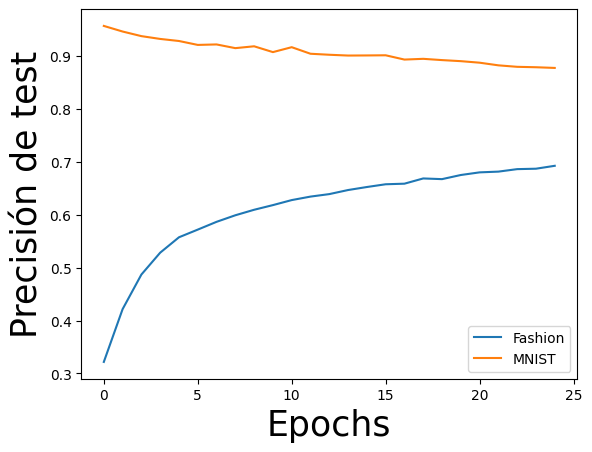

In [39]:
# Convertir los tensores a numpy arrays en la CPU
accuracy = [acc.item() for acc in val_acc]
accuracy2 = [acc.item() for acc in val2_acc]

plt.figure()
plt.plot(accuracy, label='Fashion')
plt.plot(accuracy2, label='MNIST')
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Precisión de test', fontsize=25)
plt.legend()
plt.show()

In [40]:
model_A_B = torch.load("models/taskA_B.pth")
#loaded_model = SimpleCNN()  # Create an instance of your model
loaded_model = CNN()
loaded_model.load_state_dict(torch.load("models/CNN_A_B.pth")) #se carga el modelo pre-entrenado si se desea

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)  # Modelo cargado a GPU

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

### Modificación de Datasets con permutación aleatoria

Con el objetivo de probar nuevos datasets y plantear soluciones al problema encontrado en la red CNN usada, he decidido implementar un enfoque diferente en el Aprendizaje de Tareas Incrementales, donde en lugar de cambiar un dataset por otro, voy a permutar las imágenes de MNIST y hacer que el modelo aprenda tanto a clasificar los números de sus imágenes, como a descomponer el ruido de su nuevo dataset.

In [41]:
def add_noise(image, added_noise):
    """
    Función para añadir ruido aleatorio a las imágenes 
    y crear un dataset permutado de MNiST. Puede servir
    para cualquier otro dataset de imágenes.

    Inputs:
    image = imagen a la que añadir ruido aleatorio
    """
    noise = torch.randn_like(image) * added_noise
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0.0, 1.0)

def permuted_MNIST(loader, noise):
    # Separo las imágenes y etiquetas del conjunto de entrenamiento
    images = []
    labels = []

    for batch_images, batch_labels in loader:
        images.append(batch_images)
        labels.append(batch_labels)

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)

    # Apply noise to the permuted images
    permuted_images = torch.stack([add_noise(img, noise) for img in images])
    
    # Creo un nuevo conjunto de datos con las imágenes permutadas y las etiquetas originales
    permuted_dataset_mnist = TensorDataset(permuted_images, labels)
    
    # Defino un DataLoader para el conjunto de datos de entrenamiento permutado
    batch_size = 32
    permuted_loader_mnist = DataLoader(permuted_dataset_mnist, batch_size=batch_size, shuffle=False)

    return permuted_loader_mnist

In [42]:
# Se permuta el conjunto de entrenamiento MNIST con un ruido aleatorio de 2.0
train_loader_permuted = permuted_MNIST(train_loader_mnist, 2.) 

In [43]:
# Se permuta el conjunto de test MNIST con un ruido aleatorio de 2.0
test_loader_permuted = permuted_MNIST(test_loader_mnist, 2.)

Se comprueba que tanto el conjunto de datos de entrenamiento como el de test tienen aplicada una permutación adecuada en sus imágenes.

Número dentro de la imagen: 7
Tamaño de la imagen: torch.Size([28, 28])


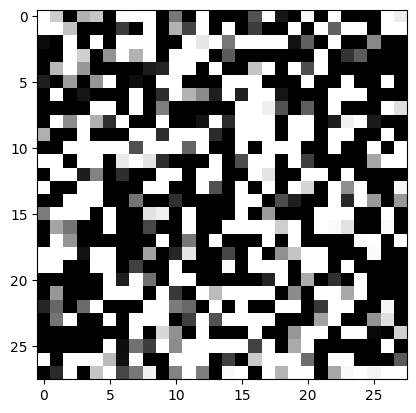

In [44]:
input_image, target_label = next(iter(train_loader_permuted))

print("Número dentro de la imagen:",target_label[0].item())
print("Tamaño de la imagen:",input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255)
plt.imshow(img)

Número dentro de la imagen: 7
Tamaño de la imagen: torch.Size([28, 28])


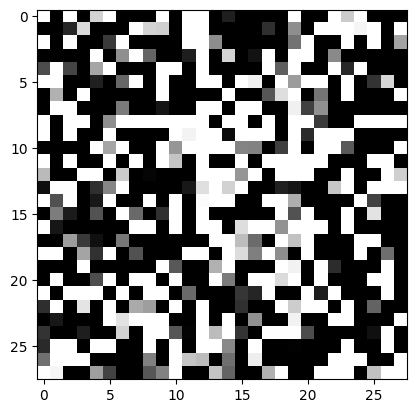

In [45]:
input_image, target_label = next(iter(test_loader_permuted))

print("Número dentro de la imagen:",target_label[0].item())
print("Tamaño de la imagen:",input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255)
plt.imshow(img)

En ninguno de los dos casos la imagen es reconocible a simple vista por el ojo humano, donde visualmente, pocas diferencias podemos encontrar entre los dos números mostrados arriba.

In [185]:
# Se permite cargar el modelo pre entrenado en lugar de realizar entrenamientos de cero
model = torch.load("models/taskA.pth")

if torch.cuda.is_available() and use_cuda:
    model.cuda() #modelo a GPU

acc_mnist = test(model,test_loader_mnist) #Precisión actual del modelo para la tarea A
acc_permuted = test(model,test_loader_permuted) #Precisión actual del modelo para la tarea B
    
print('Precisión en Tarea A (MNIST): {} %'.format(acc_mnist*100))
print('Precisión en Tarea B (Permuted): {} %'.format(acc_permuted*100))

Precisión en Tarea A (MNIST): 71.34000396728516 %
Precisión en Tarea B (Permuted): 20.979999542236328 %


### Re entrenamiento con Descenso de Gradiente Estocástico

In [186]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc,  model = default_train(
    model,
    epochs = 25,
    train_loader = train_loader_permuted,
    test_loader = test_loader_permuted,
    test2_loader = test_loader_mnist,
)

  0%|          | 0/25 [00:00<?, ?it/s]

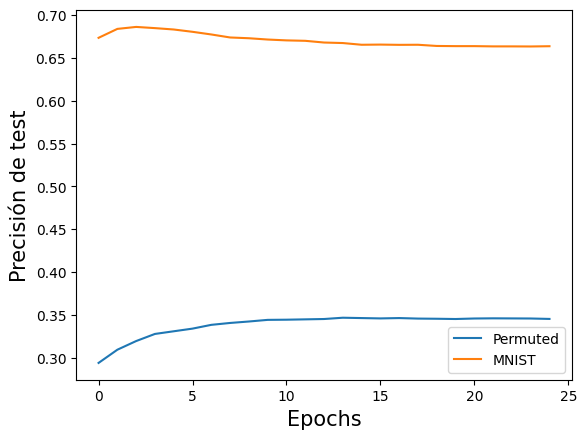

In [187]:
plt.figure()
plt.plot(val_acc, label='Permuted')
plt.plot(val2_acc, label='MNIST')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Precisión de test', fontsize=15)
plt.legend()
plt.show()

In [ ]:
torch.save(model, "models/taskA_B_permuted.pth")

### Re entrenamiento con Consolidación de Pesos Elástica

In [188]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc, model = ewc_training(
    ewc = ewc,
    importance = 1000,
    model = model,
    epochs = 25,
    train_loader = train_loader_permuted,
    test_loader = test_loader_permuted,
    test2_loader = test_loader_mnist,
)

  0%|          | 0/25 [00:00<?, ?it/s]

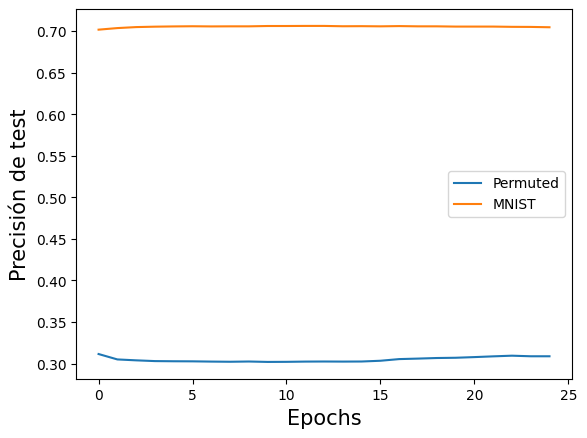

In [189]:
plt.figure()
plt.plot(val_acc, label='Permuted')
plt.plot(val2_acc, label='MNIST')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Precisión de test', fontsize=15)
plt.legend()
plt.show()

In [190]:
torch.save(model, "models/EWC_taskA_B_permuted.pth")

# Prueba con múltiples tareas aprendidas por una red

In [46]:
def baseline_training_3(
    model, 
    epochs, 
    train_loader,
    test_loader,
    test2_loader = None,
    test3_loader = None,
    use_cuda=True, 
):
    
    """
    This function saves the training curve data consisting
    training set loss and validation set accuracy over the
    course of the epochs of training.
    
    I set this up such that if you provide 2 test sets,you
    can watch the test accuracy change together during training
    on train_loder
    """
    
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
        
    train_loss, val_acc, val2_acc, val3_acc = [], [], [], []
    
    for epoch in tqdm(range(epochs)):

        epoch_loss = one_epoch_baseline(model,train_loader)
        train_loss.append(epoch_loss)
        
        acc = test(model,test_loader)
        val_acc.append(acc.detach().cpu().numpy())
        
        if test2_loader is not None:
            acc2 = test(model,test2_loader)
            val2_acc.append(acc2.detach().cpu().numpy())

        if test3_loader is not None:
            acc3 = test(model,test3_loader)
            val3_acc.append(acc3.detach().cpu().numpy())
            
    return train_loss, val_acc, val2_acc, val3_acc, model 

In [48]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc, val3_acc, model = baseline_training_3(
    model_A_B,
    epochs = 25,
    train_loader = train_loader_permuted,
    test_loader = test_loader_fashion,
    #train_loader = permuted_train_loader_mnist,
    #test_loader = permuted_test_loader_mnist,
    test2_loader = test_loader_mnist,
    test3_loader =  test_loader_permuted
)

torch.save(model, "SGD_3.pth")

  0%|          | 0/25 [00:00<?, ?it/s]

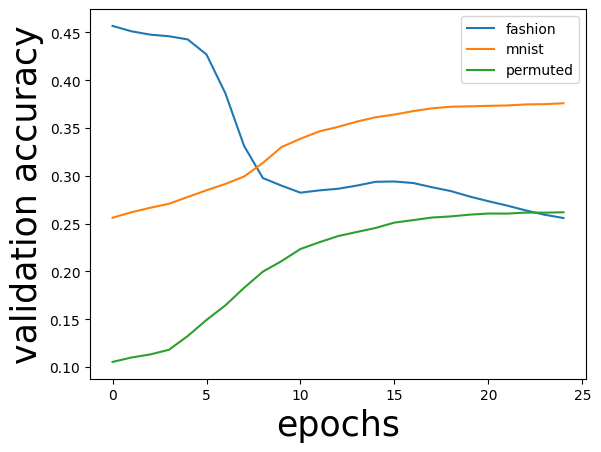

In [49]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
#plt.plot(val_acc, label='permuted')
plt.plot(val_acc, label='fashion')
plt.plot(val2_acc, label='mnist')
plt.plot(val3_acc, label='permuted')
plt.legend()
plt.show()

In [60]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc, val3_acc, model = baseline_training_3(
    loaded_model,
    epochs = 25,
    train_loader = train_loader_permuted,
    test_loader = test_loader_fashion,
    #train_loader = permuted_train_loader_mnist,
    #test_loader = permuted_test_loader_mnist,
    test2_loader = test_loader_mnist,
    test3_loader =  test_loader_permuted
)

torch.save(model, "SGD_CNN_3.pth")

  0%|          | 0/25 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 32, 28, 28] to have 1 channels, but got 32 channels instead

In [ ]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
#plt.plot(val_acc, label='permuted')
plt.plot(val_acc, label='fashion')
plt.plot(val2_acc, label='mnist')
plt.plot(val3_acc, label='permuted')
plt.legend()
plt.show()

In [73]:
model_A_B = torch.load("models/taskA_B.pth")
#loaded_model = SimpleCNN()  # Create an instance of your model
loaded_model = CNN()
loaded_model.load_state_dict(torch.load("models/CNN_A_B.pth")) #se carga el modelo pre-entrenado si se desea

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)  # Modelo cargado a GPU

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [66]:
def ewc_training_3(
    ewc,
    importance,
    model, 
    epochs, 
    train_loader,
    test_loader,
    test2_loader = None,
    test3_loader = None,
    use_cuda=True, 
):
    
    """
    This function saves the training curve data consisting
    training set loss and validation set accuracy over the
    course of the epochs of training.
    
    I set this up such that if you provide 2 test sets,you
    can watch the test accuracy change together during training
    on train_loder
    """
    
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
        
    train_loss, val_acc, val2_acc, val3_acc = [], [], [], []
    
    for epoch in tqdm(range(epochs)):

        epoch_loss = ewc_train_loss(ewc,importance, model,train_loader)
        train_loss.append(epoch_loss)
        
        acc = test(model,test_loader)
        val_acc.append(acc.detach().cpu().numpy())
        
        if test2_loader is not None:
            acc2 = test(model,test2_loader)
            val2_acc.append(acc2.detach().cpu().numpy())

        if test3_loader is not None:
            acc3 = test(model,test3_loader)
            val3_acc.append(acc3.detach().cpu().numpy())
            
    return train_loss, val_acc, val2_acc, val3_acc, model 

In [77]:
#PARA QUE ESTE ENTRENAMIENTO FUNCIONA HAY QUE VOLVER A INSTANCIAR EL EWC INICIAL PENSADO PARA MLP
ewc = EWC(model_A_B, old_tasks)

{'fc1.weight': Parameter containing:
tensor([[-0.0111, -0.0098, -0.0183,  ...,  0.0328, -0.0320, -0.0265],
        [ 0.0107,  0.0041,  0.0207,  ...,  0.0078,  0.0040,  0.0063],
        [ 0.0205, -0.0215,  0.0298,  ...,  0.0084,  0.0251, -0.0070],
        ...,
        [ 0.0278,  0.0187,  0.0237,  ...,  0.0194,  0.0335, -0.0166],
        [ 0.0315,  0.0159, -0.0296,  ..., -0.0040, -0.0242,  0.0093],
        [-0.0315, -0.0186, -0.0303,  ...,  0.0035,  0.0115, -0.0138]],
       device='cuda:0', requires_grad=True), 'fc1.bias': Parameter containing:
tensor([-0.0035,  0.0284, -0.0021, -0.0280,  0.0246,  0.1142,  0.0076, -0.0069,
         0.0193, -0.0350,  0.0263, -0.0198, -0.0212,  0.0226, -0.0037,  0.0169,
         0.0245, -0.0296,  0.0241, -0.0485,  0.0043,  0.0231, -0.0721, -0.0191,
        -0.0073,  0.0524, -0.0275,  0.0445,  0.0655, -0.0103, -0.0048,  0.0131,
        -0.0292, -0.0688, -0.0135, -0.0157,  0.0466,  0.0597, -0.0329,  0.0191,
         0.0856, -0.0271,  0.0412, -0.0568,  0.009

In [78]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc, val3_acc, model = ewc_training_3(
    ewc = ewc,
    importance = 1000,
    model = model_A_B,
    epochs = 25,
    train_loader = train_loader_permuted,
    test_loader = test_loader_fashion,
    #train_loader = permuted_train_loader_mnist,
    #test_loader = permuted_test_loader_mnist,
    test2_loader = test_loader_mnist,
    test3_loader = test_loader_permuted,
)

torch.save(model, "MLP_EWC_3.pth")

  0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

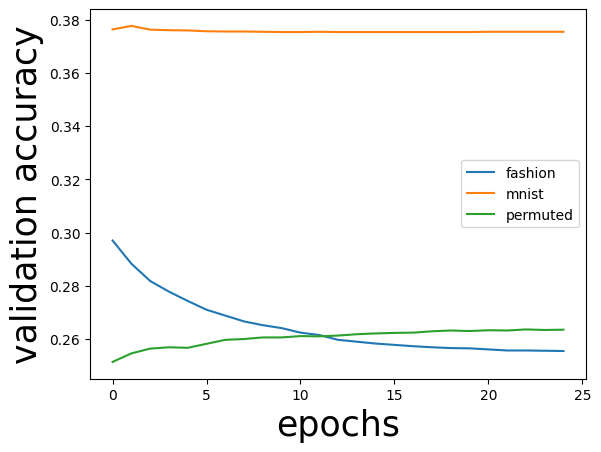

In [62]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
#plt.plot(val_acc, label='permuted')
plt.plot(val_acc, label='fashion')
plt.plot(val2_acc, label='mnist')
plt.plot(val3_acc, label='permuted')
plt.legend()
plt.show()

In [ ]:
#INSTANCIAR EWC PARA CNN
ewc = EWC(loaded_model, old_tasks)

In [75]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train_loss, val_acc, val2_acc, val3_acc, model = ewc_training_3(
    ewc = ewc,
    importance = 1000,
    model = loaded_model,
    epochs = 25,
    train_loader = train_loader_permuted,
    test_loader = test_loader_fashion,
    #train_loader = permuted_train_loader_mnist,
    #test_loader = permuted_test_loader_mnist,
    test2_loader = test_loader_mnist,
    test3_loader = test_loader_permuted,
)

torch.save(model, "CNN_EWC_3.pth")

{'layer1.0.weight': Parameter containing:
tensor([[[[ 0.0355,  0.1022, -0.2962],
          [-0.2915, -0.2628,  0.2286],
          [-0.2339,  0.2193,  0.0690]]],


        [[[ 0.1167,  0.0430, -0.1743],
          [ 0.1169, -0.0446, -0.0837],
          [ 0.0576, -0.2001, -0.0740]]],


        [[[ 0.1831, -0.3321, -0.0624],
          [ 0.2831,  0.0617, -0.0801],
          [-0.2960,  0.1116, -0.3677]]],


        [[[-0.2193, -0.0429,  0.0224],
          [-0.0928,  0.3056,  0.0529],
          [ 0.1526,  0.1226, -0.3277]]],


        [[[ 0.1023, -0.2506, -0.2331],
          [ 0.1593,  0.2489,  0.1792],
          [-0.0937, -0.0231,  0.0940]]],


        [[[-0.3990,  0.1631, -0.2803],
          [ 0.0270, -0.0486, -0.2198],
          [ 0.0786,  0.2755, -0.1083]]],


        [[[-0.2698, -0.1541, -0.2639],
          [ 0.1076, -0.1811, -0.1922],
          [-0.1521,  0.2234,  0.2320]]],


        [[[ 0.1408,  0.1637, -0.0146],
          [-0.1967,  0.0926,  0.2704],
          [-0.0967, -0.2768, -0.1

  0%|          | 0/25 [00:00<?, ?it/s]

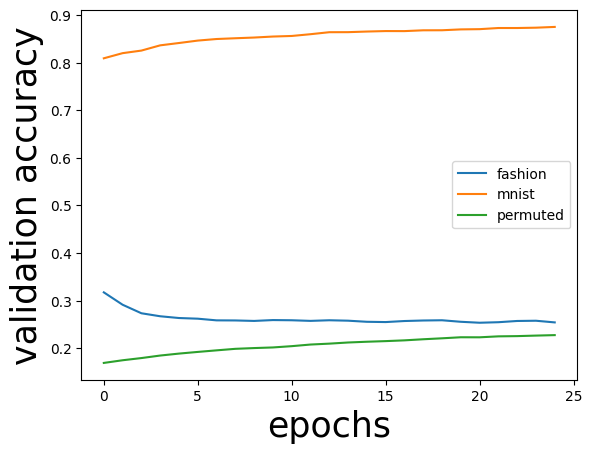

In [76]:
plt.figure()
plt.xlabel('epochs', fontsize=25)
plt.ylabel('validation accuracy', fontsize=25)
#plt.plot(val_acc, label='permuted')
plt.plot(val_acc, label='fashion')
plt.plot(val2_acc, label='mnist')
plt.plot(val3_acc, label='permuted')
plt.legend()
plt.show()